In [1]:
import math 

import ephem

from ephem import stars
from ephem import FixedBody
from ephem import Angle

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment

from matching import *
from star_catalog import get_sky
from plotter import plot_star_from_image, plot_sky_image, plot_sky_map
from star_extractor import clear_sky, star_extract

In [2]:
date = "2017/03/01"
times = ["00:02:29","00:13:58","00:25:28","00:36:57",
         "00:48:26","00:59:55","01:11:25","01:22:53",
         "01:34:23","01:45:52", "01:57:21","02:08:51",
         "02:20:20", "02:31:49", "02:43:19", "02:54:48",
         "03:06:17", "03:17:46", "03:29:15", "03:40:45"]

### Загружаем звезды с изображения

In [3]:
number = 1
skyimage = plt.imread("data/%d.gif"%number)

skyshape = skyimage.shape #Size of origin image

#Get binary array with saved star shape
stars_only, std_mask = clear_sky(skyimage)
#Binary array-image off stars and sorted stars by brightness 
stars_sky, stars_orig = star_extract(np.rot90(stars_only,3), np.rot90(std_mask,3))


#Normilize star by brithness 
max_star = max(stars_orig,  key = lambda arr:arr[0])[0]
stars_orig = sorted(stars_orig, key = lambda arr:arr[0])[::-1]
stars_orig = list(map(lambda arr:[1-(arr[0]/max_star), arr[1][0], arr[1][1]], stars_orig))
stars_without_normalize = stars_orig.copy() #coords
stars_image = np.asarray(stars_without_normalize)


### Загружаем звезды из каталога

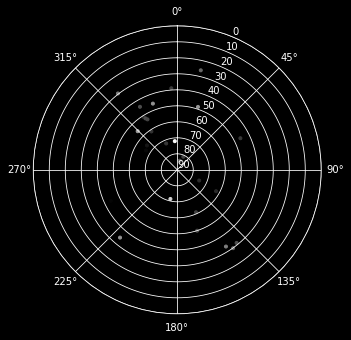

In [4]:
number = number
mercedes = ephem.Observer()
mercedes.lon = np.radians(-59.4306800)
mercedes.lat = np.radians(-34.6514500)
mercedes.elevation = 635000
mercedes.date = (date+" "+times[number])


sky, sky_data, sky_data_xy = get_sky(mercedes,alt_min = 25, top_best = 300)


sky_data_xy = [[a+2, x, y] for a,x,y in sky_data_xy ]
max_a = max(sky_data_xy, key = lambda arr:arr[0])[0]
sky_data_xy = [[(a)/max_a, x*5, (-y+100)*5] for a,x,y in sky_data_xy ]

### Sort catalog star by brighness for sky-dict format.
SKY = {'el': [], 'az':[], 'bright':[]}
sky_data = np.asarray(sky_data)
for b,az, el in sky_data:
    SKY['el'].append(el) 
    SKY['az'].append(np.radians(az)) 
    SKY['bright'].append(b) 

### Normalize brighnes
sky_data = [[a+2, x, y] for a,x,y in sky_data ]
max_a = max(sky_data, key = lambda arr:arr[0])[0]
sky_data = [[(a)/max_a, x*5, y*5] for a,x,y in sky_data ]

### stars in list format with x and y of star
stars_catalog = np.asarray(sky_data_xy)

### plotting result
plot_sky_map(sky, r='el', theta='az')

### Normilizing coords of stars  (from 0 to 100)

In [5]:
stars_catalog[:,1:] +=100
stars_image[:,1:] += 100

x = stars_catalog[:,1] 
y = stars_catalog[:,2] 
stars_catalog[:,1]  = (x - np.min(x))/(np.max(x) - np.min(x))
stars_catalog[:,2]  = (y - np.min(y))/(np.max(y) - np.min(y))


x = stars_image[:,1] 
y = stars_image[:,2] 
stars_image[:,1]  = (x - np.min(x))/(np.max(x) - np.min(x))
stars_image[:,2]  = (y - np.min(y))/(np.max(y) - np.min(y))

stars_catalog[:,1:]*=100
stars_image[:,1:]*=100

Звезды из каталога
Звезды со снимка


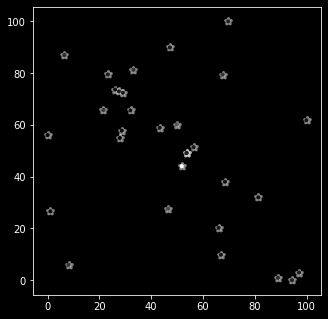

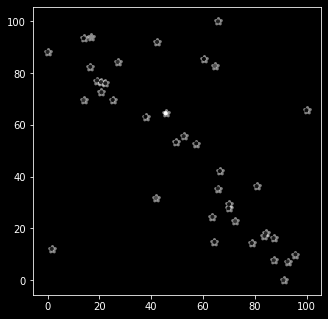

In [6]:
print("Звезды из каталога")
plot_sky_image(stars_catalog)
print("Звезды со снимка")
plot_sky_image(stars_image)

### Конвертируем изображения в сетку 

In [7]:
step = 6
image_grid = coords_to_image(stars_image[:], delta = step)
catalog_grid = coords_to_image(stars_catalog[:], delta = step)

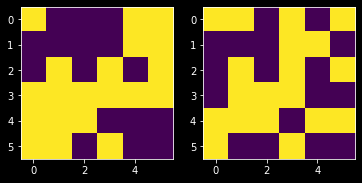

In [8]:
plt.subplot(1,2,1)
plt.imshow(image_grid)
plt.subplot(1,2,2)
plt.imshow(catalog_grid)

### Сопоставляем звезды

In [9]:
pairs, stars_catalog_sort, stars_image_sort = get_piars_image(image_grid, catalog_grid, stars_image, stars_catalog)

(20.0, 40.0) (80.0, 100.0)
(20.0, 40.0) (80.0, 100.0)
[0]
(40.0, 60.0) (20.0, 40.0)
(40.0, 60.0) (20.0, 40.0)
[0]
(40.0, 60.0) (60.0, 80.0)
(40.0, 60.0) (60.0, 80.0)
[0]
(60.0, 80.0) (20.0, 40.0)
(60.0, 80.0) (20.0, 40.0)
[2 1]
(60.0, 80.0) (40.0, 60.0)
(60.0, 80.0) (40.0, 60.0)
[]
(80.0, 100.0) (0.0, 20.0)
(80.0, 100.0) (0.0, 20.0)
[1 4]
(80.0, 100.0) (20.0, 40.0)
(80.0, 100.0) (20.0, 40.0)
[0]
(80.0, 100.0) (40.0, 60.0)
(80.0, 100.0) (40.0, 60.0)
[]


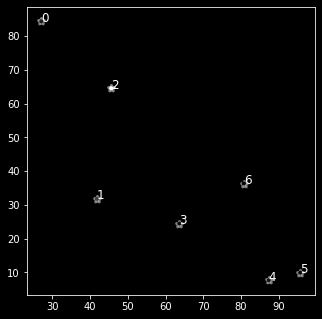

In [10]:
#Drow star-matching
stars_image_sort = np.asarray(stars_image_sort)
stars_catalog_sort = np.asarray(stars_catalog_sort)

addition_filterarr = [0,1,2,3,5,6,7]
plot_sky_image(stars_image_sort[addition_filterarr], text = True)
plot_sky_image(stars_catalog_sort[addition_filterarr], text = True)


### Получаем индексы сопоставленных звезд из начальных массивов

In [11]:
image_filter_idx = get_index(stars_image_sort[addition_filterarr], stars_image)
catalog_filter_idx = get_index(stars_catalog_sort[addition_filterarr], stars_catalog)

print("Индексы звезд из каталога: ", catalog_filter_idx)
print("Индексы звезд из изображения: ",image_filter_idx)

Индексы звезд из каталога:  [1, 2, 6, 7, 13, 19, 25]
Индексы звезд из изображения:  [0, 3, 6, 10, 19, 23, 26]


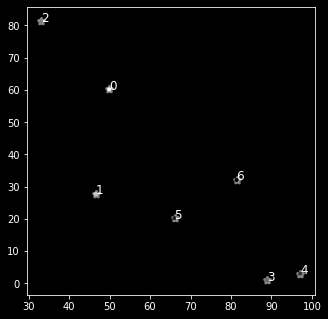

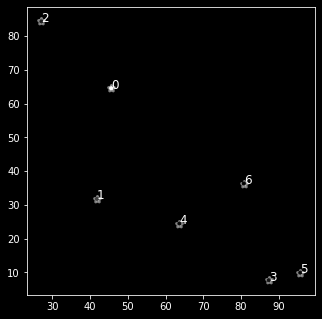

In [12]:
plot_sky_image(stars_catalog[catalog_filter_idx], text = True)
plot_sky_image(stars_image[image_filter_idx], text = True)


### Рисуем совпавшие звезды

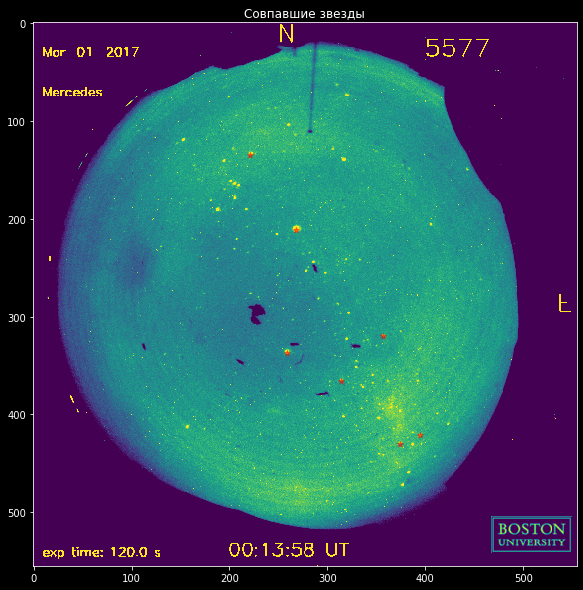

In [13]:
stars_without_normalize = np.asarray(stars_without_normalize)

plt.figure(figsize = (10, 10))
plt.imshow(np.rot90(skyimage,4))

for _,x,y in stars_without_normalize[image_filter_idx]:
    plt.scatter(x,-y+555,c='r',marker = '*', alpha = 0.5)
    
plt.title("Совпавшие звезды")
plt.show()

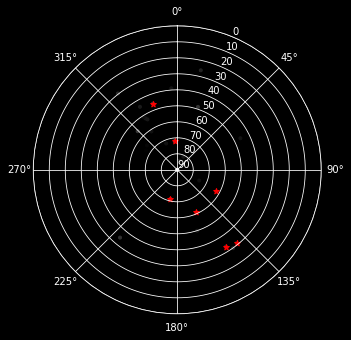

In [14]:
plot_sky_map(SKY, r='el', theta='az', points = catalog_filter_idx)

### Варпим снимок по совпавшим звездам

In [15]:
import cv2

In [16]:
objpoints = np.asarray([[[s[1],s[2],0]for s in stars_catalog_sort[addition_filterarr]]],dtype=np.float32)
imgpoints = np.asarray([[[s[1],s[2]] for s in stars_image_sort[addition_filterarr]]],dtype=np.float32)

In [17]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, skyshape ,None,None)
w,  h = skyshape
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

In [18]:
stars_from_image = stars_without_normalize[image_filter_idx][:,:]
stars_from_image[:,:-1] = stars_from_image[:,1:]
stars_from_image[:,-1] = 0

print(stars_from_image)


[[268.11111111 343.80555556   0.        ]
 [258.61111111 217.77777778   0.        ]
 [221.36363636 420.09090909   0.        ]
 [373.71428571 125.           0.        ]
 [313.8        189.6          0.        ]
 [394.8        133.6          0.        ]
 [357.         235.25         0.        ]]


In [19]:
dst = cv2.undistort(skyimage, mtx, dist, None, newcameramtx)

In [20]:
print(skyimage.shape)
plt.figure(figsize = (10,10))
plt.imshow(dst)
plt.imsave("fin.png", dst)

(555, 555)


### Варпим координаты снимка в масштабе и получаем координаты звезд после варпинга

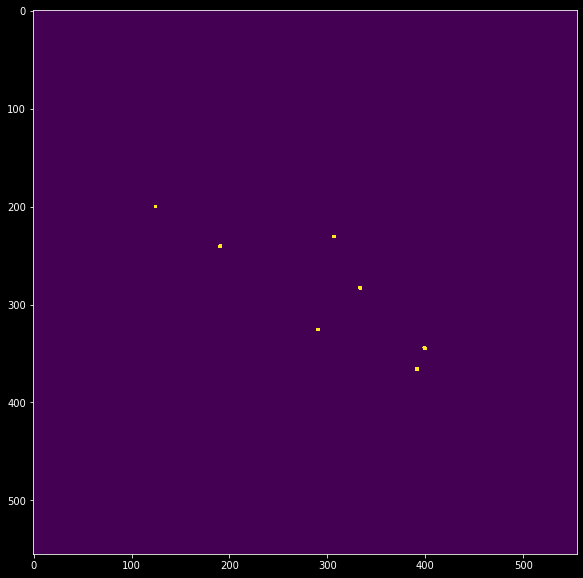

In [21]:
star_mask = np.zeros_like(skyimage)
bools = np.zeros_like(skyimage)
i = 1
p = 2
for _,x,y in stars_without_normalize[image_filter_idx]:
    star_mask[int(x)-p:int(x)+p, -int(y)+555-p:-int(y)+555+p] = i
    bools[int(x)-p:int(x)+p, -int(y)+555-p:-int(y)+555+p] = 1
    i+=1

dst = cv2.undistort(star_mask, mtx, dist, None, newcameramtx)    
dst_bools = cv2.undistort(bools, mtx, dist, None, newcameramtx)   

plt.figure(figsize = (10,10))
plt.imshow( dst_bools )
plt.show()


In [22]:
coords = star_extract_synthetic(dst_bools, dst)
transformed_coords =coords

3
2
1
5
7
4
6
[[(240.6, 190.6), 1], [(231.0, 306.5), 2], [(200.0, 124.5), 3], [(344.5625, 399.25), 4], [(283.4, 333.6), 5], [(365.5, 391.5), 6], [(325.5, 290.5), 7]]


In [23]:
# Проверяем что все ок

plt.figure(figsize = (10,10))
dst = cv2.undistort(skyimage, mtx, dist, None, newcameramtx)
plt.imshow(dst)


for arr in transformed_coords:
    pass
    plt.scatter(arr[0],arr[1],c='r',marker = '*', alpha = 0.3)
plt.show()

### Вычисляем центер 

In [30]:
xc, yc = center_calculation(stars_catalog, transformed_coords, catalog_filter_idx)

In [31]:
 def drow_circle(img, x,y, R, p = 2):
    
    width, height = img.shape[:2]
    img = img.copy()
    X = np.arange(width).reshape(width,1)
    Y = np.arange(height).reshape(1,height)
    mask_1 =  ((X - x) ** 2 + (Y - y)**2) < (R)**2
    mask_2 = ((X - x) ** 2 + (Y - y)**2) >= (R-p)**2
    img[mask_1&mask_2] = 0
  
    return img

In [33]:
plt.figure(figsize = (10,10))
dst = cv2.undistort(skyimage, mtx, dist, None, newcameramtx)
dst = drow_circle(dst,xc,yc, 3)

for x,y in transformed_coords:   
    r = distance.euclidean((int(xc+0.5),int(yc+0.5)),(int(x+0.5),int(y+0.5)))
    dst = drow_circle(dst,xc,yc, r)
    plt.scatter(x, y,c='r',marker = '*', alpha = 1)
    
plt.imshow(dst)
plt.axis(True)
plt.show()